In [3]:
import scipy.stats as ss
import numpy as np 
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import datetime

In [4]:
## black scholes formula
def d1(S0, K, r, sigma, T):
    return (np.log(S0/K) + (r + sigma**2 / 2) * T)/(sigma * np.sqrt(T))
 
def d2(S0, K, r, sigma, T):
    return (np.log(S0 / K) + (r - sigma**2 / 2) * T) / (sigma * np.sqrt(T))
 
def BlackScholes(type, S0, K, r, sigma, T):
    if type == 'call':
        return S0 * ss.norm.cdf(d1(S0, K, r, sigma, T)) - K * np.exp(-r * T) * ss.norm.cdf(d2(S0, K, r, sigma, T))
    else:
        return K * np.exp(-r * T) * ss.norm.cdf(-d2(S0, K, r, sigma, T)) - S0 * ss.norm.cdf(-d1(S0, K, r, sigma, T))

In [5]:
def readToDataFrame(input):
    """ read data from input path and return dataframe where settle date and todaydate are transfferd to datetime format
    """
    optiondata = pd.read_table( input, delimiter = ",")
    todaydate_tmp = [pd.datetime.strptime(str(x), '%Y%m%d') for x in optiondata.todaydate]
    optiondata.todaydate = todaydate_tmp
    settledate_tmp = [pd.datetime.strptime(str(x), '%Y%m%d') for x in optiondata.settledate]
    optiondata.settledate = settledate_tmp
    return optiondata.drop_duplicates()
optiondata = readToDataFrame("relevantoptions2")

In [6]:
# set risk free rate to 0.01
optiondata['rfr'] = 0.01 
optiondata['bs'] = 0

In [7]:
## use sp500 1 month realized index as volatility 
voldata = pd.read_table('vol2', delimiter = "\t")
voldata['Date'] = pd.to_datetime(voldata['date'])

In [8]:
voldata['todaydate'] = voldata['Date']
options = pd.merge(optiondata, voldata, on='todaydate', how='left')
myoptions = options
myoptions = options[options['vol']>0]
myoptions = myoptions.drop('date', 1)
myoptions = myoptions.drop('Date', 1)

In [9]:
def setBS(df):
    Price =  df.apply(lambda row: BlackScholes(row['optiontype'], row['today_sp_price'], row['optionstrike'], row['rfr'], row['vol'] /100 , row['daystosettle']/252), axis=1)
    df['bs'] = Price

setBS(myoptions)
myoptions = myoptions.dropna()

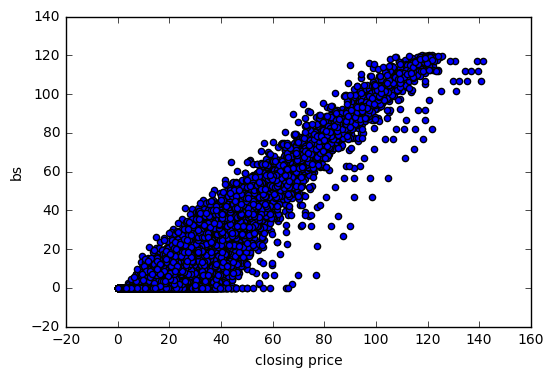

array([[ 1.        ,  0.95431971],
       [ 0.95431971,  1.        ]])

In [10]:
plt.scatter(myoptions['optionclosingprice'],myoptions['bs'] )
plt.xlabel('closing price')
plt.ylabel('bs')
plt.show()
np.corrcoef(myoptions['optionclosingprice'],myoptions['bs'])

In [11]:
myoptions['bsratio'] = (myoptions['optionclosingprice'] - myoptions['bs']) / myoptions['optionclosingprice']

In [12]:
# create dictionary to store everyday's sp500 price
def createPriceDict(row, pricedict):
    if not pricedict.has_key(row['todaydate'].strftime("%B %d, %Y")):
        pricedict[row['todaydate'].strftime("%B %d, %Y")] = row['today_sp_price']

def getPrice(df):
    """get vol and sp500 today price for each day
    """
    price = {}
    df.apply(lambda row: createPriceDict(row, price), axis=1)
    return price

priceDict = getPrice(myoptions)

In [13]:
# create dictionary to store every option's volumn, open interest rate, closing price , bsprice
def createOptionDict(row, optdict):
    if not optdict.has_key((row['todaydate'],row['settledate'],row['optiontype'],row['optionstrike'])):
        optdict[(row['todaydate'],row['settledate'],row['optiontype'],row['optionstrike'])] = (row['optionvol'],
                    row['optionopenint'], row['optionclosingprice'], row['bs'])
        
def getOption(df):
    """get vol and sp500 today price for each day
    """
    optionDic = {}
    df.apply(lambda row: createOptionDict(row, optionDic), axis=1)
    
    return optionDic

optionDic = getOption(myoptions)

In [14]:
#add sp500 yesterday's and last week's price 
def prevPrice1d(row, priceDic):
    i = 1;
    while (i < 5):
        if priceDic.has_key((row['todaydate']-datetime.timedelta(i)).strftime("%B %d, %Y")):
            return priceDic[(row['todaydate']-datetime.timedelta(i)).strftime("%B %d, %Y")]
        else:
            i+=1
    return 0

def prevPrice1week(row, priceDic):
    i = 7;
    if priceDic.has_key((row['todaydate']-datetime.timedelta(i)).strftime("%B %d, %Y")):
        return priceDic[(row['todaydate']-datetime.timedelta(i)).strftime("%B %d, %Y")]
    return 0


def addPrevPrice(df, priceDic):
    """ add s&p price of previous n days to dataframe
    """
    prvPrice =  df.apply(lambda row: prevPrice1d(row, priceDic), axis=1)
    df['sp1d'] = prvPrice
    prvweekPrice =  df.apply(lambda row: prevPrice1week(row, priceDic), axis=1)
    df['sp1w'] = prvweekPrice

addPrevPrice(myoptions,priceDict)

In [15]:
# add option's yesterday and last week's vol, openint and closing price 

def prevOption1d(row, optionDic):
    i = 1;
    while (i < 5):
        if optionDic.has_key((row['todaydate'] - datetime.timedelta(i),row['settledate'],row['optiontype'],row['optionstrike'])):
            return optionDic[((row['todaydate'] - datetime.timedelta(i)),row['settledate'],row['optiontype'],row['optionstrike'])]
        else:
            i += 1
    return -1

def prevOption1w(row, optionDic):
    i = 7;
    if optionDic.has_key((row['todaydate'] - datetime.timedelta(i),row['settledate'],row['optiontype'],row['optionstrike'])):
        return optionDic[((row['todaydate'] - datetime.timedelta(i)),row['settledate'],row['optiontype'],row['optionstrike'])]
    return -1


def addOptionDay(df, optionDic):
    # add option volume of previous n days to dataframe
    prevoptionday = df.apply(lambda row: prevOption1d(row, optionDic), axis=1)
    #print prevoptionday.head(20)
    df['volopenint%closing1d'] = prevoptionday
    prevoptionweek = df.apply(lambda row: prevOption1w(row, optionDic), axis=1)
    df['volopenint%closing1w'] = prevoptionweek
    

addOptionDay(myoptions, optionDic)

In [16]:
# select options that whose today's 500 price is within 30 of strike price 
within30data = myoptions[abs(myoptions.today_sp_price - myoptions.optionstrike)<=30]
within100data = myoptions[abs(myoptions.today_sp_price - myoptions.optionstrike)<=100]
print within100data.describe()
print within30data.describe()
haslastweek = within30data[within30data['volopenint%closing1w'] == -1]
haslastweek.describe()

       daystosettle  today_sp_price  settle_sp_price  optionstrike  \
count  48931.000000    48931.000000     48931.000000  48931.000000   
mean       8.831763     2048.921828      2056.089154   2043.230672   
std        5.163826      129.619605       130.865347    138.182215   
min        2.000000     1630.480000      1632.970000   1535.000000   
25%        4.000000     1978.350000      1978.340000   1970.000000   
50%        8.000000     2075.000000      2076.780000   2055.000000   
75%       14.000000     2117.390000      2126.060000   2130.000000   
max       19.000000     2369.750000      2381.920000   2455.000000   

       optionclosingprice  optionhighprice  optionlowprice     optionvol  \
count        48931.000000     48931.000000    48931.000000  48931.000000   
mean            14.103325        14.536102       13.550828   1917.619689   
std             20.116799        20.563367       19.655732   3526.336335   
min              0.025000         0.000000        0.000000      0

,daystosettle,today_sp_price,settle_sp_price,optionstrike,optionclosingprice,optionhighprice,optionlowprice,optionvol,optionopenint,rfr,bs,vol,bsratio,sp1d,sp1w
count,10348.000000,10348.000000,10348.000000,10348.000000,10348.000000,10348.000000,10348.000000,10348.000000,10348.000000,10348.00,10348.000000,10348.000000,10348.000000,10348.000000,10348.000000
mean,10.637708,2036.111184,2043.301015,2035.838326,16.164253,16.601058,15.546202,2046.778798,11739.439795,0.01,4.512400,12.136743,0.834461,2016.925368,1825.109317
std,5.532570,137.561984,139.540306,138.474410,11.586872,11.933428,11.359151,3411.373663,13469.818484,0.00,7.961108,5.151825,0.272014,233.276645,630.280198
min,2.000000,1630.480000,1632.970000,1610.000000,0.075000,0.000000,0.000000,0.000000,5001.000000,0.01,0.000000,4.630000,-0.736213,0.000000,0.000000
25%,4.000000,1951.360000,1961.050000,1950.000000,6.750000,7.000000,6.300000,0.000000,6051.000000,0.01,0.000000,8.390000,0.696203,1948.860000,1893.210000
50%,11.000000,2063.370000,2067.560000,2060.000000,13.950000,14.300000,13.300000,629.500000,7650.000000,0.01,0.000000,10.625000,1.000000,2060.650000,2043.410000
75%,16.000000,2109.840000,2116.100000,2120.000000,23.400000,24.100000,22.700000,2750.000000,11188.250000,0.01,6.270000,14.810000,1.000000,2109.692500,2107.400000
max,19.000000,2369.750000,2381.920000,2395.000000,87.200000,91.200000,83.200000,62304.000000,165591.000000,0.01,30.000000,31.510000,1.000000,2369.750000,2365.380000


In [18]:
# add closing price, vol, open interest and bs price of  yesterday 
def closing1day(row):
    if row['volopenint%closing1d'] == -1:
        return row['optionclosingprice']
    else:
        return row['volopenint%closing1d'][2]
    """ yesterday's closing price
    """
    
    prvPrice =  df.apply(lambda row: closing1day(row), axis=1)
    df['closing1day'] = prvPrice

def addClosing1d(df):
    """ yesterday's closing price
    """
    
    prvPrice =  df.apply(lambda row: closing1day(row), axis=1)
    df['closing1day'] = prvPrice
    
def vol1day(row):
    if row['volopenint%closing1d'] == -1:
        return row['optionvol']
    else:
        return row['volopenint%closing1d'][0]

def addvol1d(df):
    """ yesterday's volume
    """
    prvVol =  df.apply(lambda row: vol1day(row), axis=1)
    df['vol1day'] = prvVol
    #df['prevPrice1d'].hist()
    
def opint1day(row):
    if row['volopenint%closing1d'] == -1:
        return row['optionopenint']
    else:
        return row['volopenint%closing1d'][1]

def addopint1d(df):
    """ yesterday's volume
    """
    
    prvopen =  df.apply(lambda row: opint1day(row), axis=1)
    df['opint1day'] = prvopen
    #df['prevPrice1d'].hist()

def bs1day(row):
    if row['volopenint%closing1d'] == -1:
        return row['bs']
    else:
        return row['volopenint%closing1d'][3]

def addbs1d(df):
    """ yesterday's bs
    """
    
    prvbs =  df.apply(lambda row: bs1day(row), axis=1)
    df['bs1day'] = prvbs


def addYesterdayData(df):
    addClosing1d(df)
    addvol1d(df)
    addopint1d(df)
    addbs1d(df)

addYesterdayData(within30data)



/Users/mengranwang/miniconda2/lib/python2.7/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/mengranwang/miniconda2/lib/python2.7/site-packages/ipykernel/__main__.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/mengranwang/miniconda2/lib/python2.7/site-packages/ipykernel/__main__.py:44: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydat

In [19]:
# add closing price, vol, open interest, and bs price  of  lastweek
def closing1w(row):
    if row['volopenint%closing1w'] == -1:
        return row['closing1day']
    else:
        return row['volopenint%closing1w'][2]

def addClosing1w(df):
    """ last week's closing price
    """
    prvPrice =  df.apply(lambda row: closing1w(row), axis=1)
    df['closing1w'] = prvPrice
    
def vol1w(row):
    if row['volopenint%closing1w'] == -1:
        return row['vol1day']
    else:
        return row['volopenint%closing1w'][0]

def addvol1w(df):
    """ last week's volume
    """
    prvVol =  df.apply(lambda row: vol1w(row), axis=1)
    df['vol1w'] = prvVol
    
def opint1w(row):
    if row['volopenint%closing1w'] == -1:
        return row['opint1day']
    else:
        return row['volopenint%closing1w'][1]

def addopint1w(df):
    """ last week's open interest
    """
    prvopen =  df.apply(lambda row: opint1w(row), axis=1)
    df['opint1w'] = prvopen

def bs1w(row):
    if row['volopenint%closing1w'] == -1:
        return row['bs1day']
    else:
        return row['volopenint%closing1w'][3]

def addbs1w(df):
    """ last week's bs
    """
    
    prvbs =  df.apply(lambda row: bs1w(row), axis=1)
    df['bs1w'] = prvbs

def addLastWeekData(df):
    addClosing1w(df)
    addvol1w(df)
    addopint1w(df)
    addbs1w(df)

addLastWeekData(within30data)

/Users/mengranwang/miniconda2/lib/python2.7/site-packages/ipykernel/__main__.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/mengranwang/miniconda2/lib/python2.7/site-packages/ipykernel/__main__.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/mengranwang/miniconda2/lib/python2.7/site-packages/ipykernel/__main__.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydat

In [20]:
#add ratios 
# if bs price = 0, ratio = 1

def closing1dayratio(row):
    return row['optionclosingprice']/row['closing1day']

def addClosing1dratio(df):
    prvPrice =  df.apply(lambda row: closing1dayratio(row), axis=1)
    df['closing1dayratio'] = prvPrice
    
def bs1dayratio(row):
    if (row['bs1day'] == 0):
        return 1
    return row['bs']/row['bs1day']

def addbs1dratio(df):
    prvPrice =  df.apply(lambda row: bs1dayratio(row), axis=1)
    df['bs1dayratio'] = prvPrice
    
    
def opint1dayratio(row):
    return float(row['optionopenint'])/row['opint1day']

def addopint1dratio(df):
    prvopen =  df.apply(lambda row: opint1dayratio(row), axis=1)
    df['opint1dayratio'] = prvopen
    #df['prevPrice1d'].hist()

def closing1wratio(row):
    return row['optionclosingprice']/row['closing1w']

def addClosing1wratio(df):
    """ last week's closing price
    """
    
    prvPrice =  df.apply(lambda row: closing1wratio(row), axis=1)
    df['closing1wratio'] = prvPrice
    
def opint1wratio(row):
     return float(row['optionopenint'])/row['opint1w']

def addopint1w(df): 
    prvopen =  df.apply(lambda row: opint1wratio(row), axis=1)
    df['opint1wratio'] = prvopen

def bs1wratio(row):
    if (row['bs1w'] == 0):
        return 1
    return float(row['bs'])/row['bs1w']

def addbs1w(df): 
    prvopen =  df.apply(lambda row: bs1wratio(row), axis=1)
    df['bs1wratio'] = prvopen
    

    

def addRatio(df):
    addopint1w(df)
    addClosing1wratio(df)
    addbs1dratio(df)
    addbs1w(df)
    addopint1dratio(df)
    addClosing1dratio(df)
    
addRatio(within30data)

/Users/mengranwang/miniconda2/lib/python2.7/site-packages/ipykernel/__main__.py:44: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/mengranwang/miniconda2/lib/python2.7/site-packages/ipykernel/__main__.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/mengranwang/miniconda2/lib/python2.7/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydat

In [21]:
#remove unrelated columns 
cleandata = within30data.drop(['optionhighprice','optionlowprice','optionvol','volopenint%closing1d',
                               'volopenint%closing1w','closing1day','vol1day','opint1day','closing1w',
                               'vol1w','opint1w','rfr','vol'], axis=1)
cleandata = cleandata[cleandata['sp1d']!=0]
cleandata = cleandata[cleandata['sp1w']!=0]
cleandata.describe()

,daystosettle,today_sp_price,settle_sp_price,optionstrike,optionclosingprice,optionopenint,bs,bsratio,sp1d,sp1w,bs1day,bs1w,opint1wratio,closing1wratio,bs1dayratio,bs1wratio,opint1dayratio,closing1dayratio
count,17157.000000,17157.000000,17157.000000,17157.000000,17157.000000,17157.000000,17157.000000,17157.000000,17157.000000,17157.000000,17157.000000,17157.000000,17157.000000,17157.000000,17157.000000,17157.000000,17157.000000,17157.000000
mean,8.697733,2048.400743,2054.578617,2048.138661,14.997131,13997.649065,5.012481,0.801542,2046.895959,2042.650253,5.576371,6.040630,1.137135,1.249818,1.156429,1.344499,1.045429,1.122374
std,5.149504,130.428933,131.964173,131.325782,10.998138,15197.573122,8.325085,0.305412,130.452356,130.935046,10.752938,13.411024,0.308350,1.567648,3.107399,13.004981,0.144919,0.756247
min,2.000000,1630.480000,1632.970000,1610.000000,0.075000,5001.000000,0.000000,-0.492135,1630.480000,1630.480000,0.000000,0.000000,0.301567,0.021718,0.000000,0.000000,0.301567,0.087121
25%,4.000000,1977.090000,1972.290000,1975.000000,6.000000,6732.000000,0.000000,0.600424,1973.280000,1965.990000,0.000000,0.000000,1.000000,0.668103,1.000000,1.000000,0.998384,0.760870
50%,8.000000,2075.370000,2075.370000,2070.000000,12.800000,9287.000000,0.000000,1.000000,2075.000000,2075.000000,0.000000,0.000000,1.025873,1.000000,1.000000,1.000000,1.002921,1.000000
75%,14.000000,2115.480000,2122.730000,2125.000000,22.100000,14405.000000,8.090000,1.000000,2115.480000,2114.070000,7.090000,5.350000,1.174487,1.282443,1.000000,1.000000,1.056839,1.223819
max,19.000000,2369.750000,2381.920000,2395.000000,87.200000,175350.000000,30.000000,1.000000,2369.750000,2365.380000,102.390000,118.230000,5.587633,33.857143,174.000000,1048.000000,4.399506,12.344828


## group options belong to same (today date and settlement date)

Next, we are going to put the first 15 options that has strike price closest to today's sp500 corresponding to the same (today date, settlement date) in one row according to following steps:
2. sort data according to their absolute value of (strike price - today's sp500 price)
3. create a dictionary, whose key is (today date, settlement date) pair and value is a list of our interested feature of each option.(suppose m vectors for each element)
4. add each option in the dictionary.
5. adjust each dict value to include 15 options 
6. sort data according to settledate and if settledate are the same, sort the data based on today's date.
7. save data to file

In [22]:
def getOptionType(row):
    if row['optiontype']=='put':
        return 0
    else: 
        return 1
def changeType(df):
    df['type'] = df.apply(lambda row: getOptionType(row), axis = 1 )
    df['optiontype']=df['type']
    


def diffStrikeSp500(row):
    return abs(row['optionstrike']-row['today_sp_price'])
def sortAbs(df):
    df['abs'] = df.apply(lambda row: diffStrikeSp500(row), axis = 1 )
    return df.sort_values(by = 'abs') 

changeType(cleandata)
cleandata = sortAbs(cleandata)

In [23]:
def addToDict(row, optiondict):
    if optiondict.has_key((row['todaydate'],row['settledate'])):
        if len(optiondict[(row['todaydate'],row['settledate'])]) != 15:
            optiondict[(row['todaydate'],row['settledate'])].extend(
            [row['optiontype'],row['optionstrike'],
            row['optionclosingprice'], row['optionopenint'],row['sp1d'],row['sp1w'],row['opint1wratio'],
            row['closing1wratio'],row['opint1dayratio'],row['closing1dayratio'],row['bs'],row['bs1dayratio'],row['bs1wratio']])
    else:
        optiondict[(row['todaydate'],row['settledate'])] = [row['daystosettle'],row['settle_sp_price'],row['today_sp_price'],row['optiontype'],row['optionstrike'],
        row['optionclosingprice'], row['optionopenint'],row['sp1d'] ,row['sp1w'],row['opint1wratio'],
        row['closing1wratio'],row['opint1dayratio'],row['closing1dayratio'],row['bs'],row['bs1dayratio'],row['bs1wratio']]

def createDic(df):
    myDic ={}
    df.apply(lambda row: addToDict(row, myDic), axis=1)
    return myDic


myDic = createDic(cleandata)  



In [24]:
def adjustDic(myDict):
    for k, v in myDict.items():
        if len(v) < 198:
            #print len(myDict[k])
            del myDict[k]
        else:
            myDict[k] = myDict[k][:198]
    
adjustDic(myDic)
df3=pd.DataFrame.from_dict(myDic)
df4 = df3.T
df4.reset_index(inplace=True)
df5 = df4.rename(columns={'level_1': 'settledate', 'level_0': 'todaydate'})
df5.to_csv("combinedoption2", index=False)

Summary:
    After combining options belong to the same pair, we got 276 rows and 198 features for each pair(column) 

# Training

Random Forest Regressor
    1. we divide training set and test set based on settlement date. If a option's settledate is after the half of          2015,  we use it as test data; otherwise, training data.
    2. Target: settlement day's sp500 price - today's sp500 price
          X: ['optiontype','optionstrike',
         'optionclosingprice','optionhighprice', 'optionlowprice', 'optionopenint', 
          'sp1d','sp1w','opint1wratio',
        'closing1wratio','opint1dayratio','closing1dayratio','bs1dayratio','bs1wratio' for each option and ['daystosettle', 'today_sp_price']                 for all options belong to the same (settledate, toadaydate) pair. 
    3. Train a random forest regressor

In [25]:
from sklearn.ensemble import RandomForestClassifier
from sklearn import metrics
from sklearn.metrics import confusion_matrix
from sklearn.ensemble import RandomForestRegressor
from datetime import datetime

In [26]:
def target(row):
    return row[1] - row[2]

def addTarget(df):
    """ target = settle price - today's price
    """
    t = df.apply(lambda row: target(row), axis=1)
    df['target'] = t

addTarget(df5)

In [27]:
mask1 = (df5['settledate'] < datetime.strptime('Jun 30 2015  1:33PM', '%b %d %Y %I:%M%p'))
training= df5.loc[mask1]
mask2 = (df5['settledate'] > datetime.strptime('Jun 30 2015  1:33PM', '%b %d %Y %I:%M%p'))
test= df5.loc[mask2]

col_list = list(df5)
col_list[4:200]
x_list=[0]
x_list.extend(col_list[4:200])

X_test = test.as_matrix(x_list)
y_test = test.as_matrix(['target'])[:,0]

X_train = training.as_matrix(x_list)
y_train = training.as_matrix(['target'])[:,0]



regres = RandomForestRegressor(n_estimators=1000, max_features="sqrt", n_jobs=-1, oob_score = True)
regres.fit(X_train, y_train)
pred = regres.predict(X_test)
print("Mean squared error - Test Set: %.6f"
  % np.mean((pred - y_test) ** 2))
# Explained variance score: 1 is perfect prediction
print('Variance score: %.2f' % regres.score(X_test, y_test))

pred_train = regres.predict(X_train)
print("Mean squared error - Training Set: %.6f"
  % np.mean((pred_train - y_train) ** 2))
# Explained variance score: 1 is perfect prediction
print('Variance score: %.2f' % regres.score(X_train, y_train))



Mean squared error - Test Set: 1746.429492
Variance score: -0.01
Mean squared error - Training Set: 55.391499
Variance score: 0.91


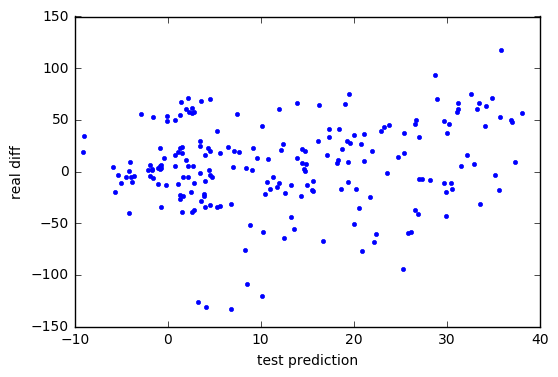

[[ 1.          0.17251457]
 [ 0.17251457  1.        ]]


In [28]:
plt.plot(pred, y_test, ".")
plt.ylabel('real diff')
plt.xlabel('test prediction')
plt.show()
print np.corrcoef(pred,y_test)

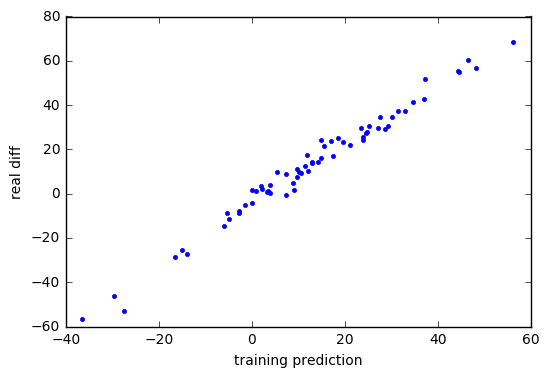

[[ 1.          0.99037337]
 [ 0.99037337  1.        ]]


In [29]:
plt.plot(pred_train, y_train, ".")
plt.ylabel('real diff')
plt.xlabel('training prediction')
plt.show()
print np.corrcoef(pred_train,y_train)

# Strategies

## Data Preparation

### Add prediction to test set

In [30]:
# get dictionary for ((today's date, settlement's date): prediction)
def createPredDict(row, pred_dict):
    if not pred_dict.has_key((row['todaydate'],row['settledate'])):
        pred_dict[(row['todaydate'],row['settledate'])] = row['pred']

def getPredict(df):
    """get predition for each today's date and settledate
    """
    prediction = {}
    df.apply(lambda row: createPredDict(row, prediction), axis=1)
    return prediction

predAll = np.append(pred_train,pred,axis=0)
df5['pred'] = predAll.tolist()
predDict = getPredict(df5)

In [31]:
## get dataframe for testing
mask3 = (cleandata['settledate'] > datetime.strptime('Jun 30 2015  1:33PM', '%b %d %Y %I:%M%p'))
testdf= cleandata.loc[mask3]

In [32]:
## add sp500 difference prediction to each option

def getPred(row,pred_dict):
    if pred_dict.has_key((row['todaydate'],row['settledate'])):
        return pred_dict[(row['todaydate'],row['settledate'])]
    else:
        return 0

def changePred(df, pred_dict):
    pred0 = df.apply(lambda row: getPred(row, pred_dict), axis=1)
    df['pred'] = pred0
        
changePred(testdf, predDict)

/Users/mengranwang/miniconda2/lib/python2.7/site-packages/ipykernel/__main__.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


## First Startegy

In [33]:
testdf['pl']= 0

def compPL(row, pred_dict, multiplier):
    if row.pred == 0:
        return 0
    else:
        if row.pred > 0:
            if row.optionstrike <= row.today_sp_price and row.optiontype == 0: #put
                if row.settle_sp_price >= row.optionstrike:
                    #print row.optionclosingprice
                    return row.optionclosingprice*multiplier
                else:
                    #print row.optionclosingprice + multiplier * (row.settle_sp_price - row.optionstrike)
                    return row.optionclosingprice*multiplier + multiplier * (row.settle_sp_price - row.optionstrike)
        elif row.pred < 0:
            if row.optionstrike >= row.today_sp_price and row.optiontype == 1: #call
                if row.settle_sp_price <= row.optionstrike:
                    #print row.optionclosingprice
                    return row.optionclosingprice*multiplier
                else:
                    #print row.optionclosingprice - multiplier * (row.settle_sp_price - row.optionstrike)
                    return row.optionclosingprice*multiplier - multiplier * (row.settle_sp_price - row.optionstrike)
        else:
            return 0
def getPl(df, pred_dict):
    pl0 = df.apply(lambda row: compPL(row, pred_dict, 1), axis=1)
    df['pl'] = pl0
            
    
getPl(testdf, predDict)
testdf['pl'].fillna(0, inplace=True)

/Users/mengranwang/miniconda2/lib/python2.7/site-packages/ipykernel/__main__.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':
/Users/mengranwang/miniconda2/lib/python2.7/site-packages/ipykernel/__main__.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/mengranwang/miniconda2/lib/python2.7/site-packages/pandas/core/generic.py:3191: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/i

In [34]:
## result of first strategy
positivedf = testdf 
neagtivedf = testdf 
positivedf = testdf[testdf.pl > 0]
negativedf = testdf[testdf.pl < 0]

In [35]:
print negativedf.describe()
print positivedf.describe()
print "profit is "+ str(positivedf['pl'].sum())
print "loss is " + str(negativedf['pl'].sum())

       daystosettle  today_sp_price  settle_sp_price  optiontype  \
count    232.000000      232.000000       232.000000  232.000000   
mean       6.706897     2108.138922      2067.023362    0.185345   
std        4.641274       94.635991       129.767206    0.389417   
min        2.000000     1923.670000      1880.020000    0.000000   
25%        3.000000     2077.070000      1970.890000    0.000000   
50%        4.000000     2091.540000      2023.040000    0.000000   
75%        9.000000     2179.980000      2147.260000    0.000000   
max       18.000000     2328.250000      2347.220000    1.000000   

       optionstrike  optionclosingprice  optionopenint     bs  bsratio  \
count    232.000000          232.000000     232.000000  232.0    232.0   
mean    2099.547414            9.195366   19717.719828    0.0      1.0   
std      103.717220            5.442616   19355.242186    0.0      0.0   
min     1895.000000            0.225000    5002.000000    0.0      1.0   
25%     2055.0000

### plot histogram for total profit and loss based on each other numbers day out 


In [72]:
### create new data frame, columns: numbers of days out, total profit, total loss

def genPositiveDataframe(df):
    groups = df.groupby('daystosettle') 
    temp = pd.DataFrame(columns=['numofdays','profit','proCount','proAvg'])
    for name, group in groups:
        temp = temp.append({'numofdays': name,
     'profit':  group.pl.sum(),
     'proCount': group.pl.count(),
      'proAvg': group.pl.sum() / group.pl.count()
      }, ignore_index=True)
    return temp

def genNegativeDataframe(df):
    groups = df.groupby('daystosettle') 
    temp = pd.DataFrame(columns=['numofdays','loss','lossCount','lossAvg'])
    for name, group in groups:
        temp = temp.append({'numofdays': name,
     'loss':  group.pl.sum(),
     'lossCount': group.pl.count(),
     'lossAvg': group.pl.sum() / group.pl.count()                      
      }, ignore_index=True)
    return temp

pos = genPositiveDataframe(positivedf)
neg = genNegativeDataframe(negativedf)
plotdf = pos.join(neg.set_index('numofdays'), on='numofdays', how = 'outer')
plotdf['loss'].fillna(0, inplace=True)
plotdf['lossCount'].fillna(1, inplace=True)
plotdf['lossAvg'].fillna(0, inplace=True)
plotdf.numofdays = plotdf.numofdays.astype(int)
plotdf.set_index('numofdays', inplace=True)

In [40]:
plotdf

,profit,proCount,proAvg,loss,lossCount,lossAvg
numofdays,,,,,,
2.0,554.390,147.0,3.771361,-953.540,37.0,-25.771351
3.0,716.150,128.0,5.594922,-1798.955,44.0,-40.885341
4.0,595.140,93.0,6.399355,-1997.640,41.0,-48.722927
6.0,187.550,7.0,26.792857,0.000,1.0,0.000000
7.0,556.500,67.0,8.305970,-702.550,16.0,-43.909375
8.0,717.965,59.0,12.168898,-332.560,18.0,-18.475556
9.0,1024.710,72.0,14.232083,-602.140,26.0,-23.159231
10.0,1040.185,86.0,12.095174,-46.610,7.0,-6.658571
11.0,671.205,46.0,14.591413,-866.090,16.0,-54.130625


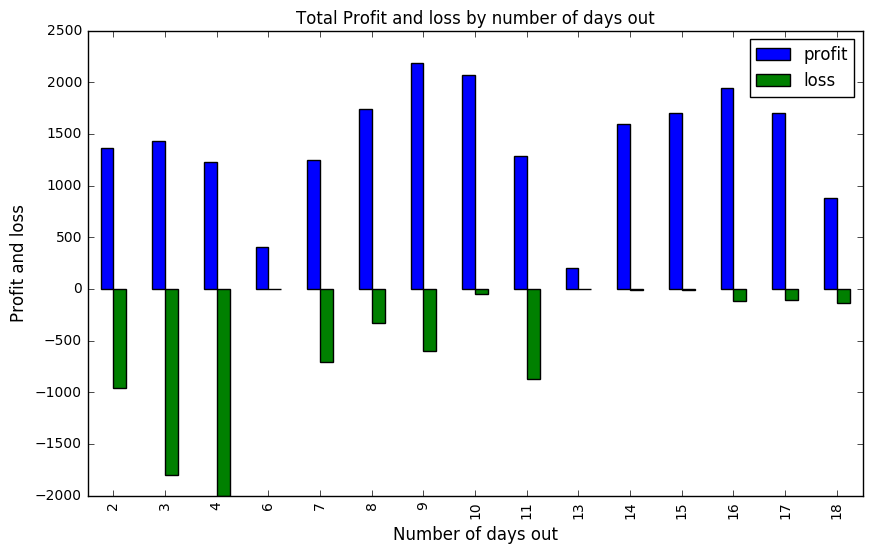

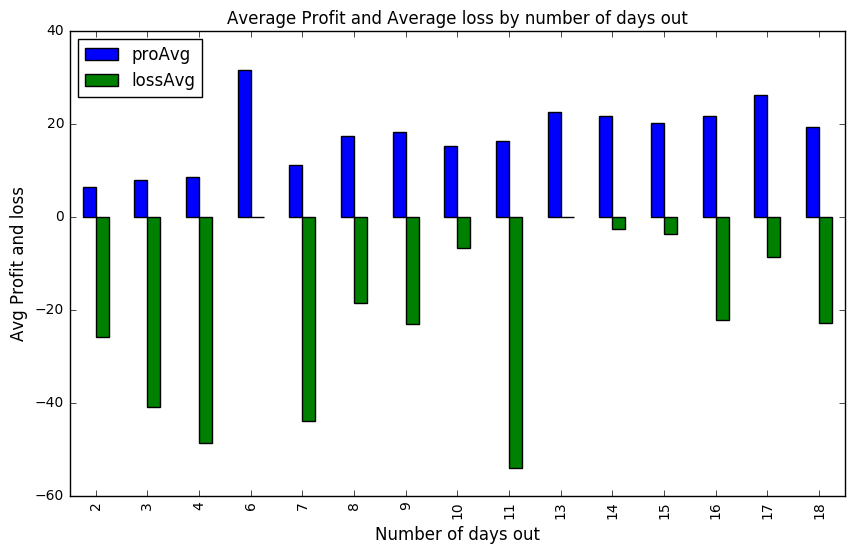

In [73]:
## plot "Total Profit and Total Loss by Number of Days Out"
ax = plotdf[['profit','loss']].plot(kind='bar', title ="Total Profit and loss by number of days out", figsize=(10, 6), legend=True, fontsize=10)
ax.set_xlabel("Number of days out", fontsize=12)
ax.set_ylabel("Profit and loss", fontsize=12)
plt.show()
## plot "Average Profit and Average Loss by Number of Days Out"
ax = plotdf[['proAvg','lossAvg']].plot(kind='bar', title ="Average Profit and Average loss by number of days out", figsize=(10, 6), legend=True, fontsize=10)
ax.set_xlabel("Number of days out", fontsize=12)
ax.set_ylabel("Avg Profit and loss", fontsize=12)
plt.show()

testdf is all the options that we are going to trade.

putdf are put options and calldf are call options

generate scatter points for put and call option where x axis is prediction and y axis is profit

In [50]:
interestedDf = testdf
interestedDf = testdf[testdf.pl!=0]
putDf = interestedDf[interestedDf.optiontype == 0]
callDf = interestedDf[interestedDf.optiontype == 1]

In [51]:
print putDf.describe()
print callDf.describe()

       daystosettle  today_sp_price  settle_sp_price  optiontype  \
count    987.000000      987.000000       987.000000       987.0   
mean       8.435664     2066.869818      2074.361641         0.0   
std        5.254445       85.925392        93.370516         0.0   
min        2.000000     1851.860000      1880.020000         0.0   
25%        3.000000     1995.830000      2023.040000         0.0   
50%        8.000000     2077.990000      2077.990000         0.0   
75%       14.000000     2104.050000      2126.640000         0.0   
max       18.000000     2292.560000      2347.220000         0.0   

       optionstrike  optionclosingprice  optionopenint     bs  bsratio  \
count    987.000000          987.000000     987.000000  987.0    987.0   
mean    2051.048632           12.701013   21506.005066    0.0      1.0   
std       86.387903            7.868701   22489.472436    0.0      0.0   
min     1825.000000            0.425000    5002.000000    0.0      1.0   
25%     1985.0000

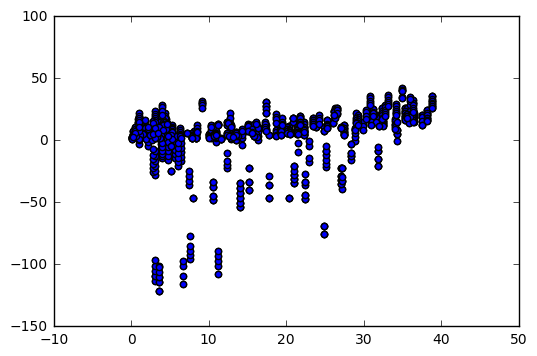

In [53]:
plt.scatter(putDf['pred'], putDf['pl'])
plt.show()

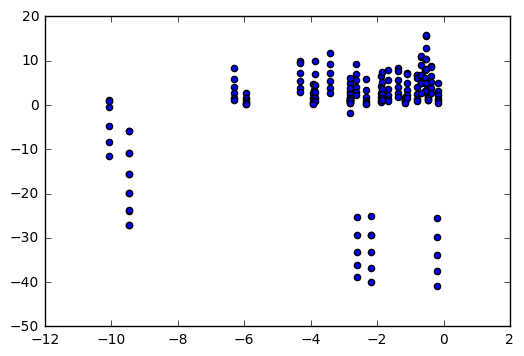

In [54]:
plt.scatter(callDf['pred'], callDf['pl'])
plt.show()

## Second Strategy

In [42]:
testdf2 = testdf
testdf2['pl']= 0

def compPL(row, pred_dict, multiplier):
    if row.pred == 0:
        return 0
    else:
        if row.pred > 0:
            if row.optionstrike <= row.today_sp_price - row.pred and row.optiontype == 0:
                if row.settle_sp_price >= row.optionstrike:
                    #print row.optionclosingprice
                    return row.optionclosingprice*multiplier
                else:
                    #print row.optionclosingprice + multiplier * (row.settle_sp_price - row.optionstrike)
                    return row.optionclosingprice*multiplier + multiplier * (row.settle_sp_price - row.optionstrike)
        elif row.pred < 0:
            if row.optionstrike >= row.today_sp_price  - row.pred and row.optiontype == 1:
                if row.settle_sp_price <= row.optionstrike:
                    #print row.optionclosingprice
                    return row.optionclosingprice*multiplier
                else:
                    #print row.optionclosingprice - multiplier * (row.settle_sp_price - row.optionstrike)
                    return row.optionclosingprice*multiplier - multiplier * (row.settle_sp_price - row.optionstrike)
        else:
            return 0
def getPl(df, pred_dict):
    pl0 = df.apply(lambda row: compPL(row, pred_dict, 1), axis=1)
    df['pl'] = pl0
            
    
getPl(testdf2, predDict)
testdf2['pl'].fillna(0, inplace=True)
    

/Users/mengranwang/miniconda2/lib/python2.7/site-packages/ipykernel/__main__.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from ipykernel import kernelapp as app
/Users/mengranwang/miniconda2/lib/python2.7/site-packages/ipykernel/__main__.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


### result of second strategy

In [43]:
positivedf2 = testdf2 
neagtivedf2 = testdf2 
positivedf2 = testdf2[testdf2.pl > 0]
negativedf2 = testdf2[testdf2.pl < 0]
print negativedf2.describe()
print positivedf2.describe()
print "profit is "+ str(positivedf2['pl'].sum())
print "loss is " + str(negativedf2['pl'].sum())

       daystosettle  today_sp_price  settle_sp_price  optiontype  \
count    129.000000      129.000000       129.000000  129.000000   
mean       7.077519     2146.035039      2110.490310    0.271318   
std        4.462714       83.655924       133.245261    0.446373   
min        2.000000     1938.680000      1880.020000    0.000000   
25%        3.000000     2081.720000      2012.370000    0.000000   
50%        7.000000     2112.130000      2077.990000    0.000000   
75%        9.000000     2186.480000      2187.120000    1.000000   
max       18.000000     2328.250000      2347.220000    1.000000   

       optionstrike  optionclosingprice  optionopenint     bs  bsratio  \
count    129.000000          129.000000     129.000000  129.0    129.0   
mean    2136.899225            6.537791   21242.356589    0.0      1.0   
std       98.242751            4.131521   18747.016787    0.0      0.0   
min     1910.000000            0.225000    5055.000000    0.0      1.0   
25%     2065.0000

### plot histogram for total profit and loss based on each other numbers day out 

In [76]:

### create new data frame numbers of days out, total profit, total loss

def genPositiveDataframe(df):
    groups = df.groupby('daystosettle') 
    temp = pd.DataFrame(columns=['numofdays','profit','proCount','proAvg'])
    for name, group in groups:
        temp = temp.append({'numofdays': name,
     'profit':  group.pl.sum(),
     'proCount': group.pl.count(),
      'proAvg': group.pl.sum() / group.pl.count()
      }, ignore_index=True)
    return temp

def genNegativeDataframe(df):
    groups = df.groupby('daystosettle') 
    temp = pd.DataFrame(columns=['numofdays','loss','lossCount','lossAvg'])
    for name, group in groups:
        temp = temp.append({'numofdays': name,
     'loss':  group.pl.sum(),
     'lossCount': group.pl.count(),
     'lossAvg': group.pl.sum() / group.pl.count()                      
      }, ignore_index=True)
    return temp

pos2 = genPositiveDataframe(positivedf2)
neg2 = genNegativeDataframe(negativedf2)
plotdf2 = pos2.join(neg2.set_index('numofdays'), on='numofdays', how = 'outer')
plotdf2['loss'].fillna(0, inplace=True)
plotdf2['lossCount'].fillna(1, inplace=True)
plotdf2['lossAvg'].fillna(0, inplace=True)
plotdf2.numofdays = plotdf2.numofdays.astype(int)
plotdf2.set_index('numofdays', inplace=True)

In [47]:
plotdf2

,profit,proCount,proAvg,loss,lossCount,lossAvg
numofdays,,,,,,
2.0,358.610,119.0,3.013529,-583.930,20.0,-29.196500
3.0,287.925,73.0,3.944178,-888.375,19.0,-46.756579
4.0,354.930,67.0,5.297463,-1076.280,17.0,-63.310588
6.0,70.050,3.0,23.350000,0.000,1.0,0.000000
7.0,203.500,39.0,5.217949,-514.160,11.0,-46.741818
8.0,157.215,27.0,5.822778,-276.890,14.0,-19.777857
9.0,256.020,29.0,8.828276,-420.710,20.0,-21.035500
10.0,422.985,51.0,8.293824,-46.410,6.0,-7.735000
11.0,125.375,14.0,8.955357,-501.900,9.0,-55.766667


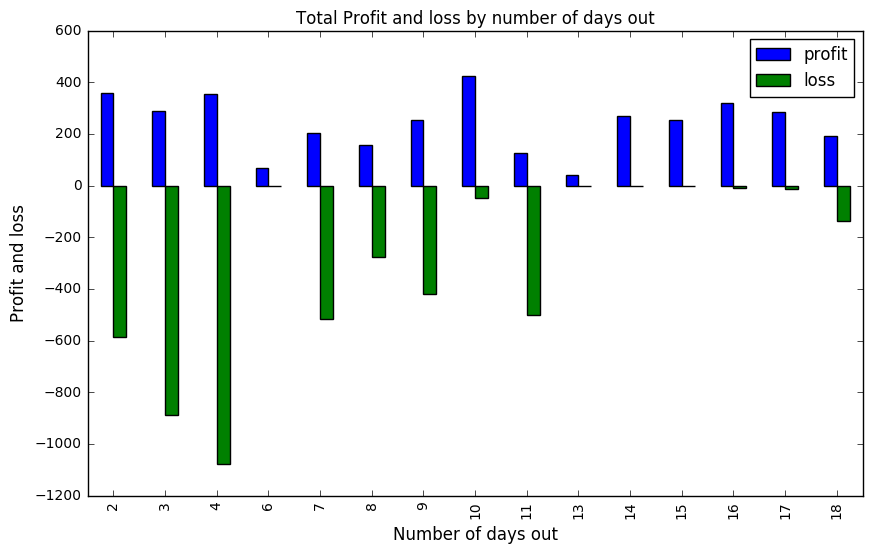

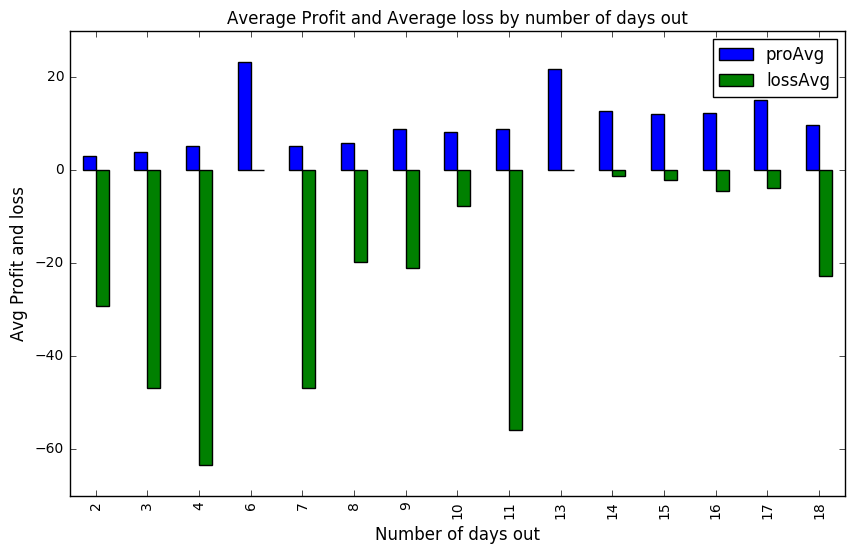

In [77]:
## plot "Total Profit and Total Loss by Number of Days Out"
ax = plotdf2[['profit','loss']].plot(kind='bar', title ="Total Profit and loss by number of days out", figsize=(10, 6), legend=True, fontsize=10)
ax.set_xlabel("Number of days out", fontsize=12)
ax.set_ylabel("Profit and loss", fontsize=12)
plt.show()
## plot "Average Profit and Average Loss by Number of Days Out"
ax = plotdf2[['proAvg','lossAvg']].plot(kind='bar', title ="Average Profit and Average loss by number of days out", figsize=(10, 6), legend=True, fontsize=10)
ax.set_xlabel("Number of days out", fontsize=12)
ax.set_ylabel("Avg Profit and loss", fontsize=12)
plt.show()

### analysis based on the days to settle date

In [49]:
X_test = test.as_matrix(x_list)
y_test = test.as_matrix(['target'])[:,0]

X_train = training.as_matrix(x_list)
y_train = training.as_matrix(['target'])[:,0]
pred = regres.predict(X_test)
pred_train = regres.predict(X_train)



In [50]:
# convert X_test, y_test, pred to df
df6 = pd.DataFrame(X_test.tolist())
df6['real'] = y_test.tolist()
df6['pred'] = pred.tolist()

In [51]:
#get day_difference list 
def createDayDiffDict(row, dayList):
    if row[0] not in dayList:
        dayList.append(row[0])

def getDayDiff(df):
    """get vol and sp500 today price for each day
    """
    dayDiff = []
    df.apply(lambda row: createDayDiffDict(row, dayDiff), axis=1)
    dayDiff.sort()
    return dayDiff

dayDiffList = getDayDiff(df6)

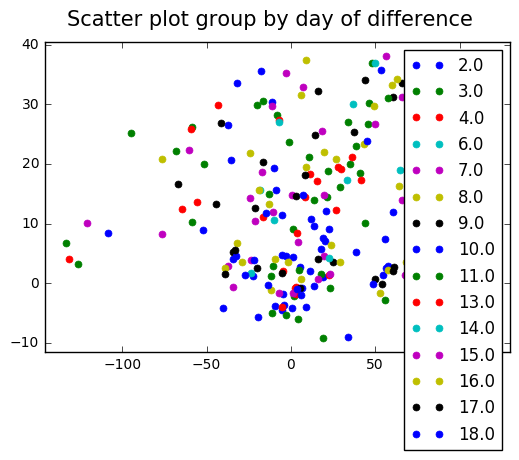

In [52]:
groups = df6.groupby(0)
fig, ax = plt.subplots()
fig.suptitle('Scatter plot group by day of difference', fontsize=15)
ax.margins(0.05) 
for name, group in groups:
    ax.plot(group.real, group.pred, marker='.', linestyle='', ms=10, label=name)
ax.legend()
plt.show()

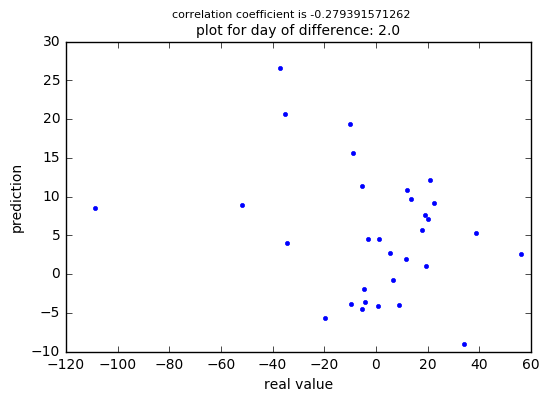

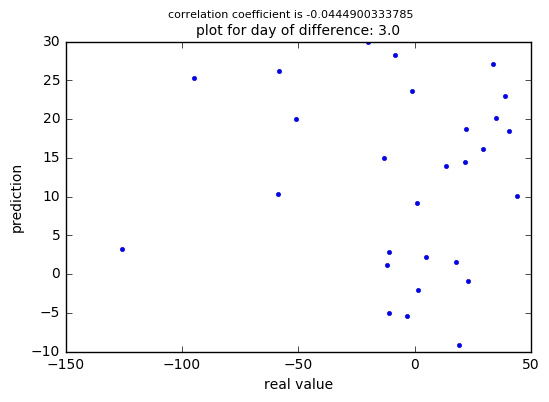

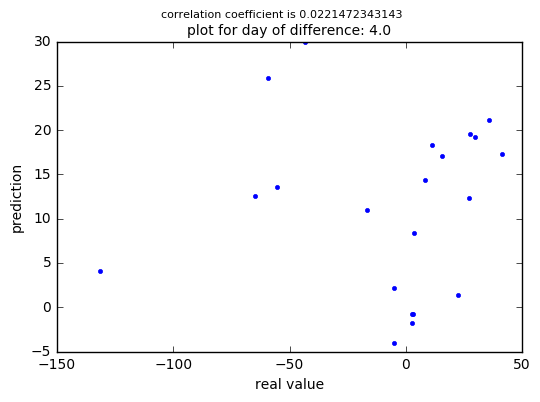

/Users/mengranwang/miniconda2/lib/python2.7/site-packages/numpy/lib/function_base.py:2487: RuntimeWarning: Degrees of freedom <= 0 for slice
  warnings.warn("Degrees of freedom <= 0 for slice", RuntimeWarning)


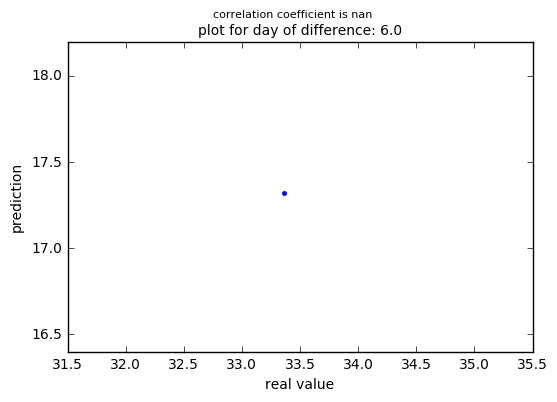

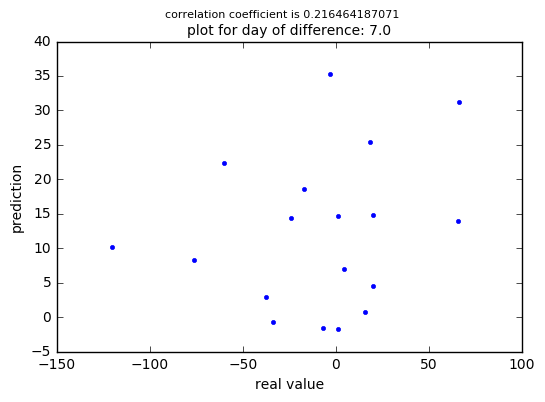

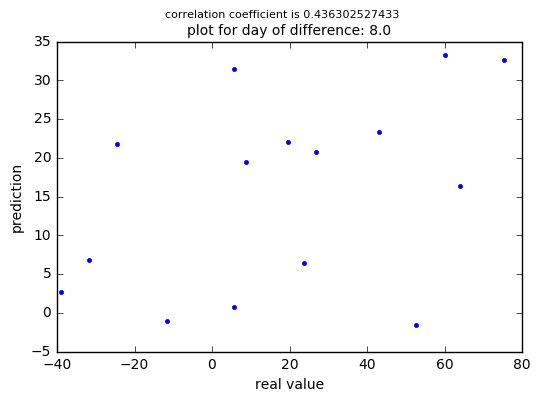

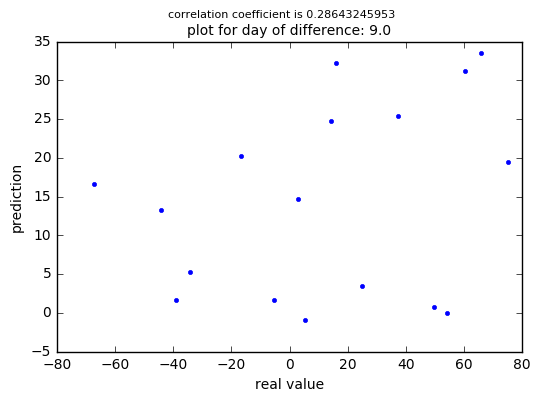

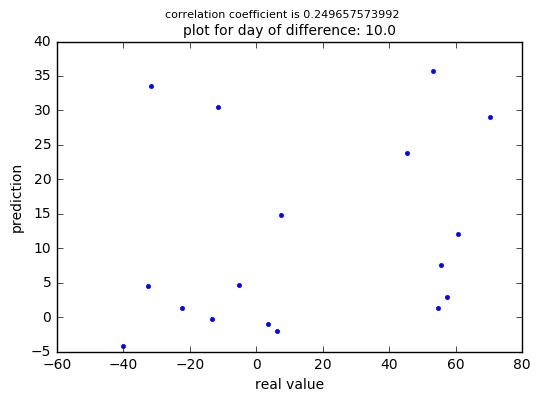

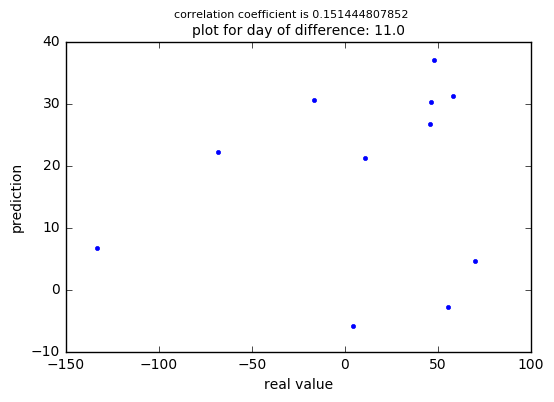

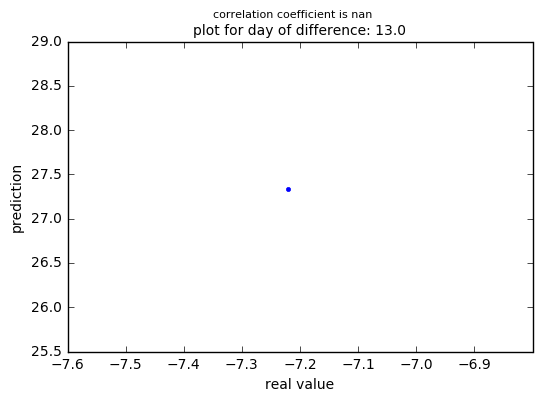

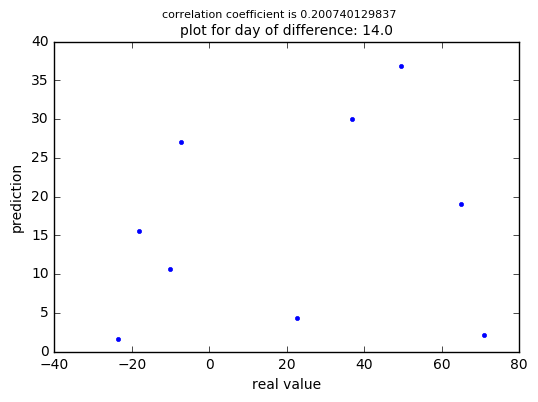

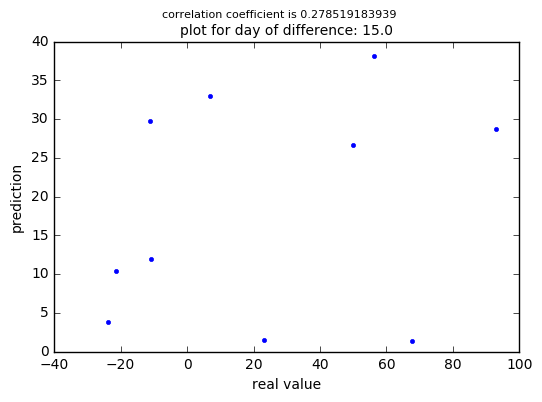

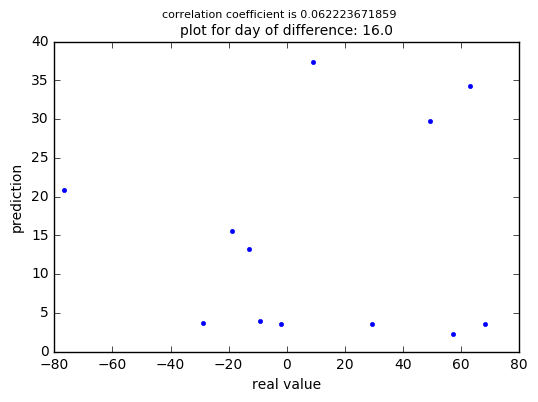

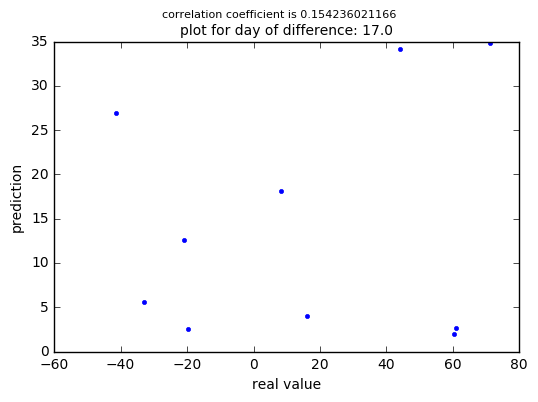

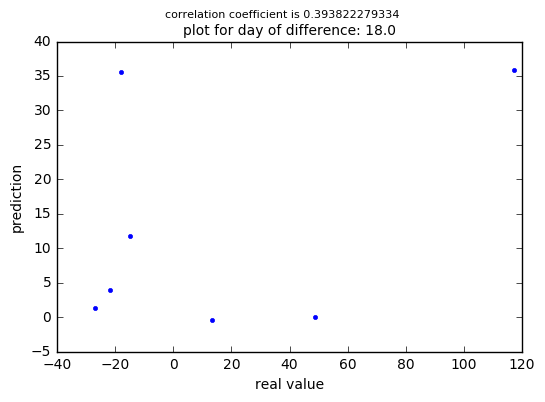

In [53]:
## generate correlation group by day of difference one by one, calculate correlation coefficient 
corrList = []
def oneDayDiff(key, df):
    df0 = df
    df0 = df[df[0]==key]
    fig = plt.figure()
    plt.xlabel('real value')
    plt.ylabel('prediction')
    plt.title('plot for day of difference: ' + str(key),  fontsize=10)
    plt.suptitle('correlation coefficient is '+ str(np.corrcoef(df0['real'],df0['pred'])[0][1]), fontsize=8)
    plt.plot(df0['real'], df0['pred'], ".")
    plt.show()
    return np.corrcoef(df0['real'],df0['pred'])[0][1]
    
    
def allDayDiff(df, dayList, corr):
    for d in dayList:
        res = oneDayDiff(d, df)
        corr.append(res)
    return corr

corrList = allDayDiff(df6, dayDiffList, corrList)

## Third Strategy

In [54]:
testdf['pl']= 0

def compPL(row, pred_dict, multiplier):
    if row.pred == 0:
        return 0
    else:
        if row.pred > 0:
            if row.optionstrike < row.today_sp_price + row.optionclosingprice and row.optiontype == 0:
                if row.settle_sp_price >= row.optionstrike:
                    #print row.optionclosingprice
                    return row.optionclosingprice*multiplier
                else:
                    #print row.optionclosingprice + multiplier * (row.settle_sp_price - row.optionstrike)
                    return row.optionclosingprice*multiplier + multiplier * (row.settle_sp_price - row.optionstrike)
        elif row.pred < 0:
            if row.optionstrike >= row.today_sp_price - row.optionclosingprice  and row.optiontype == 1:
                if row.settle_sp_price <= row.optionstrike:
                    #print row.optionclosingprice
                    return row.optionclosingprice*multiplier
                else:
                    #print row.optionclosingprice - multiplier * (row.settle_sp_price - row.optionstrike)
                    return row.optionclosingprice*multiplier - multiplier * (row.settle_sp_price - row.optionstrike)
        else:
            return 0
def getPl(df, pred_dict):
    pl0 = df.apply(lambda row: compPL(row, pred_dict, 1), axis=1)
    df['pl'] = pl0

/Users/mengranwang/miniconda2/lib/python2.7/site-packages/ipykernel/__main__.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':


### result of third strategy

In [55]:
getPl(testdf, predDict)
testdf['pl'].fillna(0, inplace=True)
interestedDf3 = testdf
interestedDf3 = testdf[testdf.pl!=0]

/Users/mengranwang/miniconda2/lib/python2.7/site-packages/ipykernel/__main__.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [59]:
positivedf3 = interestedDf3
positivedf3 = interestedDf3[interestedDf3.pl > 0]
negativedf3 = interestedDf3
negativedf3 = interestedDf3[interestedDf3.pl < 0]

In [60]:
negativedf3.describe()

,daystosettle,today_sp_price,settle_sp_price,optiontype,optionstrike,optionclosingprice,optionopenint,bs,bsratio,sp1d,...,opint1wratio,closing1wratio,bs1dayratio,bs1wratio,opint1dayratio,closing1dayratio,type,abs,pred,pl
count,474.000000,474.000000,474.000000,474.000000,474.000000,474.000000,474.000000,474.000000,474.000000,474.000000,...,474.000000,474.000000,474.000000,474.000000,474.000000,474.000000,474.000000,474.000000,474.000000,4.740000e+02
mean,6.987342,2108.394684,2075.037764,0.213080,2107.278481,16.027584,19242.567511,6.922806,0.709556,2107.219030,...,1.084807,1.072371,1.185064,1.139721,1.030884,1.063716,0.213080,13.728101,10.033410,-3.270436e+01
std,5.031807,99.992496,132.124342,0.409916,100.404459,9.217038,19916.200147,9.116440,0.347559,100.596487,...,0.221882,0.869514,2.135559,2.074554,0.131802,0.540795,0.409916,8.572051,11.140652,3.038178e+01
min,2.000000,1890.280000,1880.020000,0.000000,1895.000000,0.225000,5002.000000,0.000000,0.001767,1893.360000,...,0.581292,0.071429,0.000000,0.000000,0.708325,0.173529,0.000000,0.020000,-9.115950,-1.311600e+02
25%,3.000000,2064.197500,1970.890000,0.000000,2060.000000,8.125000,7301.000000,0.000000,0.376343,2065.300000,...,0.994344,0.536089,0.929007,0.849076,0.991502,0.713791,0.000000,6.320000,1.597945,-4.511000e+01
50%,4.000000,2094.650000,2040.040000,0.000000,2090.000000,15.400000,10880.500000,0.440000,0.970511,2099.200000,...,1.004983,0.877001,1.000000,1.000000,1.000000,1.000000,0.000000,13.325000,8.482800,-2.477500e+01
75%,10.000000,2178.150000,2147.260000,0.000000,2175.000000,22.875000,22397.750000,13.132500,1.000000,2172.470000,...,1.112044,1.075435,1.000000,1.000000,1.037413,1.160773,0.000000,20.925000,19.992270,-9.870000e+00
max,18.000000,2328.250000,2347.220000,1.000000,2345.000000,41.250000,132806.000000,29.760000,1.000000,2316.100000,...,2.291132,4.619718,26.775000,26.775000,2.107455,3.573333,1.000000,29.760000,33.528920,-4.263256e-14


In [61]:
positivedf3.describe()

,daystosettle,today_sp_price,settle_sp_price,optiontype,optionstrike,optionclosingprice,optionopenint,bs,bsratio,sp1d,...,opint1wratio,closing1wratio,bs1dayratio,bs1wratio,opint1dayratio,closing1dayratio,type,abs,pred,pl
count,1473.000000,1473.000000,1473.000000,1473.000000,1473.000000,1473.000000,1473.000000,1473.000000,1473.000000,1473.000000,...,1473.000000,1473.000000,1473.000000,1473.000000,1473.000000,1473.000000,1473.000000,1473.000000,1473.000000,1473.000000
mean,8.373388,2082.592641,2103.014033,0.190767,2078.129667,16.938544,21076.057026,4.661018,0.826022,2080.407678,...,1.102189,1.249842,1.019416,1.616763,1.035506,1.021500,0.190767,14.984358,14.980843,14.274627
std,5.125639,101.414219,96.244458,0.393039,103.131908,11.515663,21846.070881,8.084983,0.281009,102.209821,...,0.260591,2.666680,2.135731,27.318187,0.116344,0.612434,0.393039,8.846678,13.813750,10.830150
min,2.000000,1851.860000,1880.330000,0.000000,1825.000000,0.225000,5005.000000,0.000000,0.008729,1852.210000,...,0.499007,0.021718,0.000000,0.000000,0.499007,0.087121,0.000000,0.010000,-9.115950,0.040000
25%,3.000000,1999.990000,2049.580000,0.000000,2000.000000,7.350000,7817.000000,0.000000,0.670850,1993.400000,...,0.999642,0.448413,0.759843,0.396279,0.996710,0.688889,0.000000,7.230000,1.994300,5.440000
50%,8.000000,2079.060000,2089.170000,0.000000,2070.000000,15.100000,13175.000000,0.000000,1.000000,2080.410000,...,1.020990,0.843362,1.000000,1.000000,1.003099,0.933921,0.000000,14.640000,14.727450,11.800000
75%,13.000000,2168.270000,2170.860000,0.000000,2160.000000,24.300000,23567.000000,6.810000,1.000000,2164.450000,...,1.134299,1.066434,1.000000,1.000000,1.043174,1.138249,0.000000,22.560000,28.970310,21.000000
max,18.000000,2328.250000,2347.220000,1.000000,2355.000000,56.200000,149669.000000,29.530000,1.000000,2316.100000,...,4.402004,33.857143,47.389831,1048.000000,2.281036,4.575758,1.000000,29.990000,38.140790,55.850000


### plot histogram for total profit and loss based on each other numbers day out 

In [78]:
### create new data frame numbers of days out, total profit, total loss

def genPositiveDataframe(df):
    groups = df.groupby('daystosettle') 
    temp = pd.DataFrame(columns=['numofdays','profit','proCount','proAvg'])
    for name, group in groups:
        temp = temp.append({'numofdays': name,
     'profit':  group.pl.sum(),
     'proCount': group.pl.count(),
      'proAvg': group.pl.sum() / group.pl.count()
      }, ignore_index=True)
    return temp

def genNegativeDataframe(df):
    groups = df.groupby('daystosettle') 
    temp = pd.DataFrame(columns=['numofdays','loss','lossCount','lossAvg'])
    for name, group in groups:
        temp = temp.append({'numofdays': name,
     'loss':  group.pl.sum(),
     'lossCount': group.pl.count(),
     'lossAvg': group.pl.sum() / group.pl.count()                      
      }, ignore_index=True)
    return temp

pos3 = genPositiveDataframe(positivedf3)
neg3 = genNegativeDataframe(negativedf3)
plotdf3 = pos3.join(neg3.set_index('numofdays'), on='numofdays', how = 'outer')
plotdf3['loss'].fillna(0, inplace=True)
plotdf3['lossCount'].fillna(1, inplace=True)
plotdf3['lossAvg'].fillna(0, inplace=True)
plotdf3.numofdays = plotdf3.numofdays.astype(int)
plotdf3.set_index('numofdays', inplace=True)


In [65]:
plotdf3

,profit,proCount,proAvg,loss,lossCount,lossAvg
numofdays,,,,,,
2.0,1369.590,215.0,6.370186,-2282.380,84.0,-27.171190
3.0,1434.860,184.0,7.798152,-3665.825,93.0,-39.417473
4.0,1226.130,145.0,8.456069,-3407.330,71.0,-47.990563
6.0,410.550,13.0,31.580769,0.000,1.0,0.000000
7.0,1249.860,112.0,11.159464,-1257.180,28.0,-44.899286
8.0,1737.995,100.0,17.379950,-787.970,32.0,-24.624062
9.0,2188.350,120.0,18.236250,-1342.840,42.0,-31.972381
10.0,2070.055,136.0,15.220993,-219.410,24.0,-9.142083
11.0,1289.175,79.0,16.318671,-1578.870,27.0,-58.476667


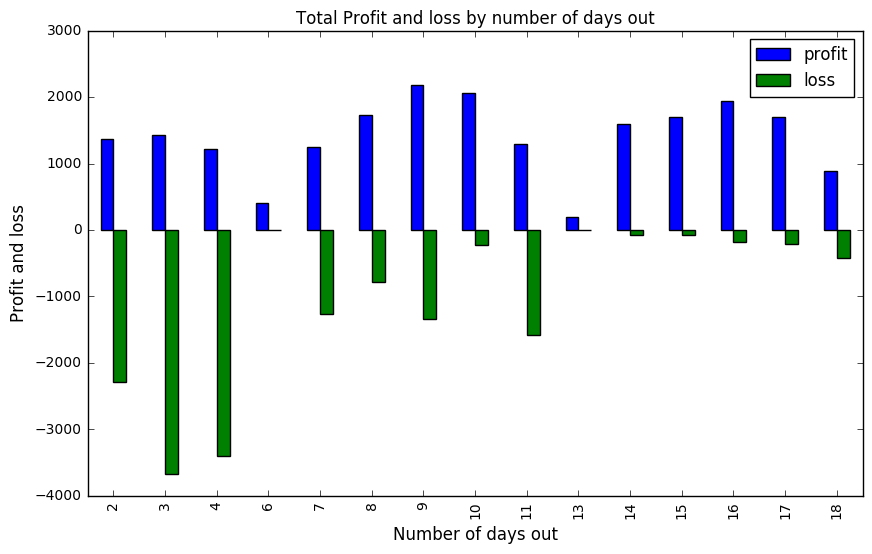

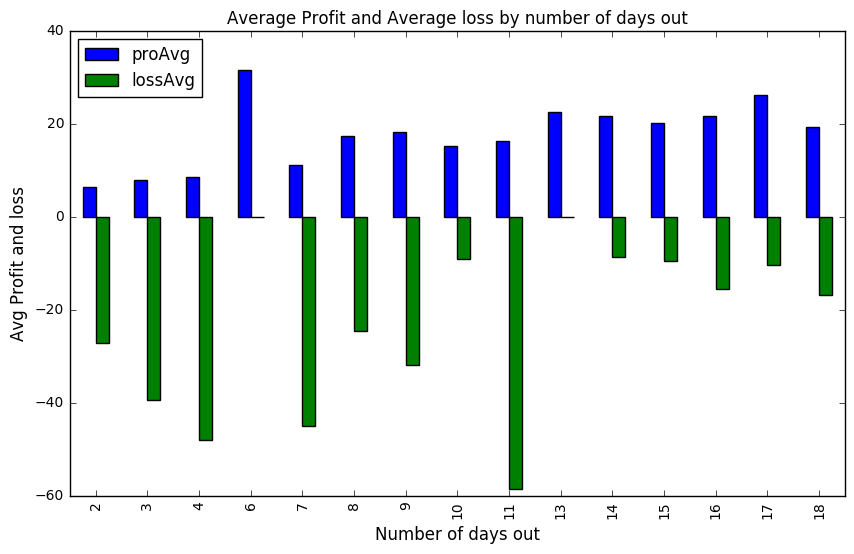

In [79]:
## plot "Total Profit and Total Loss by Number of Days Out"
ax = plotdf3[['profit','loss']].plot(kind='bar', title ="Total Profit and loss by number of days out", figsize=(10, 6), legend=True, fontsize=10)
ax.set_xlabel("Number of days out", fontsize=12)
ax.set_ylabel("Profit and loss", fontsize=12)
plt.show()
## plot "Average Profit and Average Loss by Number of Days Out"
ax = plotdf3[['proAvg','lossAvg']].plot(kind='bar', title ="Average Profit and Average loss by number of days out", figsize=(10, 6), legend=True, fontsize=10)
ax.set_xlabel("Number of days out", fontsize=12)
ax.set_ylabel("Avg Profit and loss", fontsize=12)
plt.show()

In [68]:
def plSummary(df):
    positivedf = df
    neagtivedf = df
    positivedf = df[df.pl > 0]
    negativedf = df[df.pl < 0]
    print "profit is "+ str(positivedf['pl'].sum())
    print "loss is " + str(negativedf['pl'].sum())

    
interestedDf3.describe()
plSummary(interestedDf3)

profit is 21026.525
loss is -15501.865


### calculate sharpe ratio based on days to settle date and plot P&l distribution based on days to settle date

In [75]:
#get day_difference list 
def createDayDiffDict(row, dayList):
    if row.daystosettle not in dayList:
        dayList.append(row.daystosettle)

def getDayDiff(df):
    dayDiff = []
    df.apply(lambda row: createDayDiffDict(row, dayDiff), axis=1)
    dayDiff.sort()
    return dayDiff

dayDiffList = getDayDiff(interestedDf3)

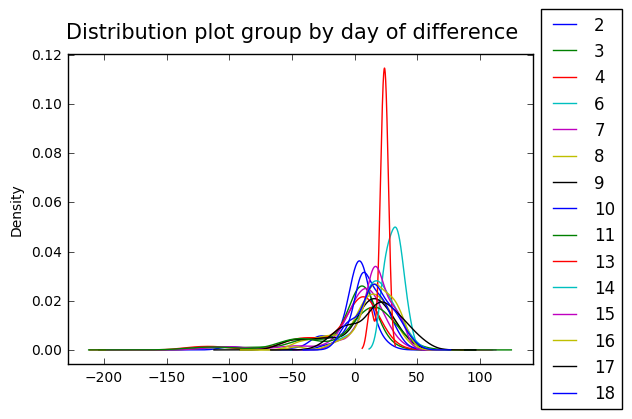

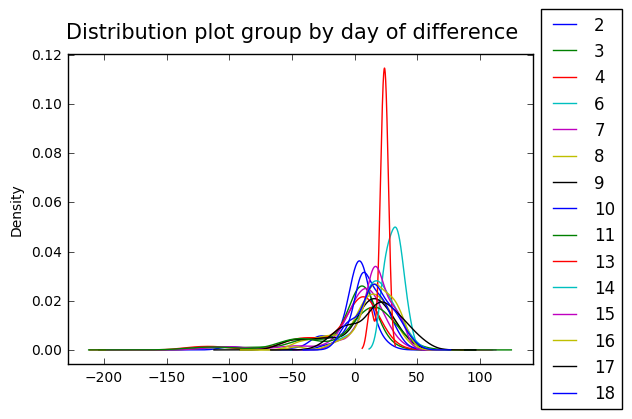

In [80]:
## draw pl distribution for each number of days 
def plotDistribution(df):
    groups = df.groupby('daystosettle')
    fig, ax = plt.subplots()
    fig.suptitle('Distribution plot group by day of difference', fontsize=15)
    ax.margins(0.05) 
    
    for name, group in groups:
        group.pl.plot(kind='kde', label=name)
        ##ax.plot(group.real, group.pred, marker='.', linestyle='', ms=10, label=name)
    # Put a legend to the right of the current axis
    ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    
plotDistribution(interestedDf3)
plt.show()

In [77]:
def computeSharpeRatio(df):
    return df['pl'].mean() / df['pl'].std()

def getSharpeRatio(df):
    groups = df.groupby('daystosettle')
    res = []
    for name, group in groups:
        tmp = computeSharpeRatio(group)
        res.append((name, tmp))
    return res

SharpeList = getSharpeRatio(interestedDf3)
print SharpeList

[(2, -0.14086094638020513), (3, -0.25058086176623678), (4, -0.29643507984297596), (6, 4.8741661189301286), (7, -0.0017944492300422624), (8, 0.34091858016523513), (9, 0.20686034370125145), (10, 0.88139022165351655), (11, -0.073704600255705202), (13, 5.611222538009363), (14, 1.3293559450765033), (15, 1.3659055129805246), (16, 1.0628867689638228), (17, 0.89131842806095229), (18, 1.1451755335026925)]
